# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

In [3]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_9.h5'
model_name = r'D:\github\fish-tracking\train\models\tank_model.h5'
validation_split = .1
use_skeleton = False

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

%load_ext autoreload
%autoreload 2

data_generator = DataGenerator(dataset, zeros_to_nan=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## view sample frame

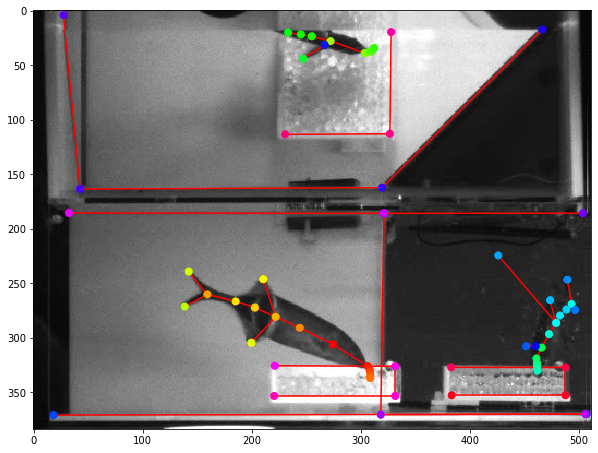

106
total frames: 144


In [7]:
frame_num = np.random.choice(len(data_generator))
image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(10,10))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)
print('total frames:', len(data_generator))

In [ ]:
plt.fi

## set up image augmentation

In [14]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

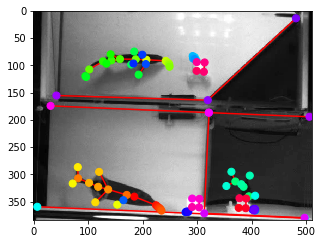

In [15]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [16]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=.1, 
                                    use_graph=use_skeleton,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 130,
 'n_validation': 14,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_9.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 144,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# check `TrainingGenerator` output

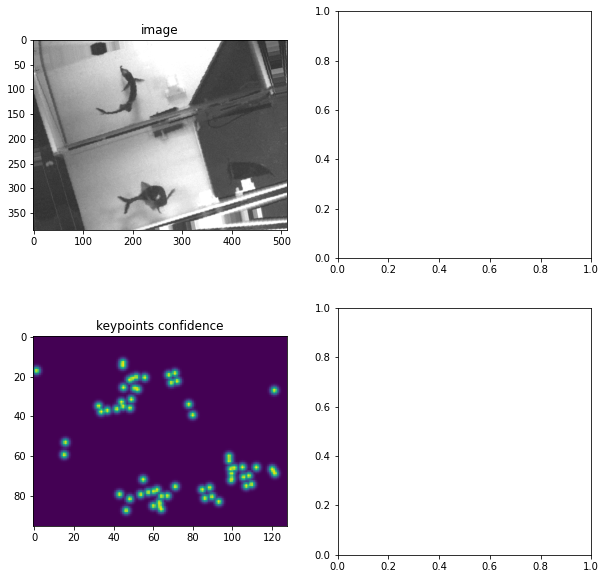

In [17]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

if use_skeleton:
    ax2.set_title('posture graph')
    ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

if use_skeleton:
    ax4.set_title('posture graph and keypoints confidence')
    ax4.imshow(outputs[0,...,-1], vmin=0)

plt.show()
train_generator.on_epoch_end()

# define a model

In [18]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 130,
 'n_validation': 14,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_9.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 144,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [19]:
batch_size = 32
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:256], batch_size=batch_size)  # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 104s 10ms/sample
95.75722323558826


# define training callbacks

In [20]:
logger = Logger(validation_batch_size=2,  # make sure this isn't too big!
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/800
15/16 [===========================>..] - ETA: 0s - loss: 42.0364 - output_0_loss: 13.9433 - output_1_loss: 14.0836 - output_2_loss: 14.0094evaluation_metrics: 
euclidean - mean: 54788.53 (0%:  1.35, 5%: 18.04, 25%: 180.34, 50%: 325.26, 75%: 141718.40, 95%: 141923.45, 100%: 142008.51) 
confidence - mean:  0.00 (0%:  0.00, 5%:  0.00, 25%:  0.00, 50%:  0.00, 75%:  0.01, 95%:  0.01, 100%:  0.01) 


Epoch 00001: val_loss improved from inf to 47.63277, saving model to D:\github\fish-tracking\train\models\tank_model.h5
16/16 [==============================] - 18s 1s/step - loss: 42.2478 - output_0_loss: 14.0243 - output_1_loss: 14.1485 - output_2_loss: 14.0750 - val_loss: 47.6328 - val_output_0_loss: 15.8891 - val_output_1_loss: 15.8516 - val_output_2_loss: 15.8921
Epoch 2/800
15/16 [===========================>..] - ETA: 0s - loss: 41.3155 - output_0_loss: 13.9725 - output_1_loss: 13.7328 - output_2_loss: 13.6102evaluation_metrics: 
euclidean - mean: 54772.85 (0%:  0.58, 5%:  3.6

Epoch 12/800
15/16 [===========================>..] - ETA: 0s - loss: 28.3498 - output_0_loss: 11.4108 - output_1_loss: 8.8896 - output_2_loss: 8.0495evaluation_metrics: 
euclidean - mean: 54743.17 (0%:  0.11, 5%:  1.07, 25%: 11.78, 50%: 233.26, 75%: 141775.13, 95%: 141944.95, 100%: 141994.27) 
confidence - mean:  0.06 (0%:  0.00, 5%:  0.01, 25%:  0.01, 50%:  0.02, 75%:  0.06, 95%:  0.26, 100%:  0.59) 


Epoch 00012: val_loss improved from 45.60259 to 43.73764, saving model to D:\github\fish-tracking\train\models\tank_model.h5
16/16 [==============================] - 14s 867ms/step - loss: 28.4060 - output_0_loss: 11.4192 - output_1_loss: 8.9107 - output_2_loss: 8.0761 - val_loss: 43.7376 - val_output_0_loss: 15.1987 - val_output_1_loss: 14.4273 - val_output_2_loss: 14.1116
Epoch 13/800
15/16 [===========================>..] - ETA: 0s - loss: 27.9971 - output_0_loss: 11.3736 - output_1_loss: 8.7080 - output_2_loss: 7.9156evaluation_metrics: 
euclidean - mean: 54746.50 (0%:  0.04, 5%:  

Epoch 23/800
15/16 [===========================>..] - ETA: 0s - loss: 23.5186 - output_0_loss: 10.2581 - output_1_loss: 7.0144 - output_2_loss: 6.2461evaluation_metrics: 
euclidean - mean: 54733.30 (0%:  0.22, 5%:  1.08, 25%:  4.36, 50%: 244.37, 75%: 141747.43, 95%: 141944.10, 100%: 142015.92) 
confidence - mean:  0.13 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.03, 75%:  0.17, 95%:  0.59, 100%:  0.84) 


Epoch 00023: val_loss did not improve from 34.99333
16/16 [==============================] - 14s 850ms/step - loss: 23.3368 - output_0_loss: 10.1872 - output_1_loss: 6.9592 - output_2_loss: 6.1905 - val_loss: 38.6139 - val_output_0_loss: 14.2366 - val_output_1_loss: 12.3767 - val_output_2_loss: 12.0006
Epoch 24/800
15/16 [===========================>..] - ETA: 0s - loss: 23.0007 - output_0_loss: 10.0515 - output_1_loss: 6.8582 - output_2_loss: 6.0910evaluation_metrics: 
euclidean - mean: 54728.10 (0%:  0.08, 5%:  1.12, 25%:  5.17, 50%: 243.29, 75%: 141708.17, 95%: 141939.28, 100%: 1419

16/16 [==============================] - 14s 868ms/step - loss: 18.8503 - output_0_loss: 9.1462 - output_1_loss: 5.1675 - output_2_loss: 4.5366 - val_loss: 24.5712 - val_output_0_loss: 10.8941 - val_output_1_loss: 7.1047 - val_output_2_loss: 6.5724
Epoch 46/800
15/16 [===========================>..] - ETA: 0s - loss: 18.4115 - output_0_loss: 8.9935 - output_1_loss: 5.0318 - output_2_loss: 4.3862evaluation_metrics: 
euclidean - mean: 54706.35 (0%:  0.13, 5%:  0.62, 25%:  1.80, 50%: 10.25, 75%: 141800.74, 95%: 141952.10, 100%: 142017.79) 
confidence - mean:  0.34 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.14, 75%:  0.71, 95%:  0.93, 100%:  1.11) 


Epoch 00046: val_loss did not improve from 24.57121
16/16 [==============================] - 13s 840ms/step - loss: 18.6882 - output_0_loss: 9.0994 - output_1_loss: 5.1195 - output_2_loss: 4.4693 - val_loss: 25.0153 - val_output_0_loss: 10.9083 - val_output_1_loss: 7.3560 - val_output_2_loss: 6.7511
Epoch 47/800
15/16 [========================

Epoch 69/800
15/16 [===========================>..] - ETA: 0s - loss: 16.2204 - output_0_loss: 8.2293 - output_1_loss: 4.2947 - output_2_loss: 3.6965evaluation_metrics: 
euclidean - mean: 54696.69 (0%:  0.08, 5%:  0.54, 25%:  1.69, 50%:  8.28, 75%: 141788.75, 95%: 141953.38, 100%: 142015.70) 
confidence - mean:  0.39 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.27, 75%:  0.79, 95%:  0.92, 100%:  1.09) 


Epoch 00069: val_loss did not improve from 22.86136
16/16 [==============================] - 13s 841ms/step - loss: 16.3179 - output_0_loss: 8.2853 - output_1_loss: 4.3209 - output_2_loss: 3.7118 - val_loss: 23.5206 - val_output_0_loss: 10.2817 - val_output_1_loss: 6.8742 - val_output_2_loss: 6.3646
Epoch 70/800
15/16 [===========================>..] - ETA: 0s - loss: 16.5583 - output_0_loss: 8.2492 - output_1_loss: 4.4562 - output_2_loss: 3.8528evaluation_metrics: 
euclidean - mean: 54692.10 (0%:  0.09, 5%:  0.52, 25%:  1.62, 50%:  6.19, 75%: 141716.64, 95%: 141950.32, 100%: 142013.97) 

Epoch 92/800
15/16 [===========================>..] - ETA: 0s - loss: 14.7652 - output_0_loss: 7.7641 - output_1_loss: 3.8078 - output_2_loss: 3.1932evaluation_metrics: 
euclidean - mean: 54694.68 (0%:  0.12, 5%:  0.60, 25%:  1.67, 50%:  7.86, 75%: 141735.33, 95%: 141955.21, 100%: 142026.74) 
confidence - mean:  0.40 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.28, 75%:  0.79, 95%:  0.92, 100%:  1.06) 


Epoch 00092: val_loss did not improve from 20.94186
16/16 [==============================] - 13s 839ms/step - loss: 14.7812 - output_0_loss: 7.7560 - output_1_loss: 3.8240 - output_2_loss: 3.2012 - val_loss: 22.4757 - val_output_0_loss: 9.8216 - val_output_1_loss: 6.5608 - val_output_2_loss: 6.0933
Epoch 93/800
15/16 [===========================>..] - ETA: 0s - loss: 15.0798 - output_0_loss: 7.8577 - output_1_loss: 3.9245 - output_2_loss: 3.2976evaluation_metrics: 
euclidean - mean: 54692.76 (0%:  0.10, 5%:  0.54, 25%:  1.58, 50%:  6.05, 75%: 141789.42, 95%: 141950.67, 100%: 142018.29) 


Epoch 104/800
15/16 [===========================>..] - ETA: 0s - loss: 14.0194 - output_0_loss: 7.4405 - output_1_loss: 3.5816 - output_2_loss: 2.9973evaluation_metrics: 
euclidean - mean: 54693.00 (0%:  0.04, 5%:  0.39, 25%:  1.49, 50%:  5.42, 75%: 141778.27, 95%: 141957.64, 100%: 142018.21) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.38, 75%:  0.83, 95%:  0.95, 100%:  1.21) 


Epoch 00104: val_loss improved from 20.86950 to 20.05384, saving model to D:\github\fish-tracking\train\models\tank_model.h5
16/16 [==============================] - 14s 868ms/step - loss: 14.2099 - output_0_loss: 7.4974 - output_1_loss: 3.6530 - output_2_loss: 3.0596 - val_loss: 20.0538 - val_output_0_loss: 9.0514 - val_output_1_loss: 5.7374 - val_output_2_loss: 5.2651
Epoch 105/800
15/16 [===========================>..] - ETA: 0s - loss: 14.7399 - output_0_loss: 7.7019 - output_1_loss: 3.8262 - output_2_loss: 3.2118evaluation_metrics: 
euclidean - mean: 54694.21 (0%:  0.11, 5%:  0.59,

Epoch 116/800
15/16 [===========================>..] - ETA: 0s - loss: 13.6212 - output_0_loss: 7.3014 - output_1_loss: 3.4636 - output_2_loss: 2.8563evaluation_metrics: 
euclidean - mean: 54696.03 (0%:  0.06, 5%:  0.41, 25%:  1.51, 50%:  5.89, 75%: 141777.06, 95%: 141956.23, 100%: 142017.31) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.37, 75%:  0.85, 95%:  0.97, 100%:  1.12) 


Epoch 00116: val_loss improved from 20.05384 to 19.68507, saving model to D:\github\fish-tracking\train\models\tank_model.h5
16/16 [==============================] - 14s 871ms/step - loss: 13.5500 - output_0_loss: 7.2477 - output_1_loss: 3.4550 - output_2_loss: 2.8473 - val_loss: 19.6851 - val_output_0_loss: 8.9756 - val_output_1_loss: 5.5857 - val_output_2_loss: 5.1237
Epoch 117/800
15/16 [===========================>..] - ETA: 0s - loss: 13.5808 - output_0_loss: 7.3385 - output_1_loss: 3.4318 - output_2_loss: 2.8105evaluation_metrics: 
euclidean - mean: 54694.39 (0%:  0.06, 5%:  0.42,

16/16 [==============================] - 14s 866ms/step - loss: 13.0856 - output_0_loss: 6.9324 - output_1_loss: 3.3661 - output_2_loss: 2.7871 - val_loss: 18.8683 - val_output_0_loss: 8.5822 - val_output_1_loss: 5.2957 - val_output_2_loss: 4.9904
Epoch 128/800
15/16 [===========================>..] - ETA: 0s - loss: 13.3348 - output_0_loss: 7.0132 - output_1_loss: 3.4596 - output_2_loss: 2.8621evaluation_metrics: 
euclidean - mean: 54698.72 (0%:  0.03, 5%:  0.43, 25%:  1.52, 50%:  5.97, 75%: 141738.54, 95%: 141958.11, 100%: 142017.36) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.41, 75%:  0.82, 95%:  0.94, 100%:  1.06) 


Epoch 00128: val_loss did not improve from 18.86831
16/16 [==============================] - 14s 845ms/step - loss: 13.4158 - output_0_loss: 7.0347 - output_1_loss: 3.4855 - output_2_loss: 2.8956 - val_loss: 19.3449 - val_output_0_loss: 8.8103 - val_output_1_loss: 5.4362 - val_output_2_loss: 5.0985
Epoch 129/800
15/16 [========================

Epoch 140/800
15/16 [===========================>..] - ETA: 0s - loss: 13.2151 - output_0_loss: 6.8925 - output_1_loss: 3.4569 - output_2_loss: 2.8657evaluation_metrics: 
euclidean - mean: 54689.54 (0%:  0.06, 5%:  0.45, 25%:  1.50, 50%:  5.51, 75%: 141760.98, 95%: 141948.94, 100%: 142018.44) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.36, 75%:  0.86, 95%:  0.96, 100%:  1.15) 


Epoch 00140: val_loss did not improve from 18.86831
16/16 [==============================] - 13s 840ms/step - loss: 13.2204 - output_0_loss: 6.9139 - output_1_loss: 3.4488 - output_2_loss: 2.8577 - val_loss: 19.4575 - val_output_0_loss: 8.6014 - val_output_1_loss: 5.5918 - val_output_2_loss: 5.2643
Epoch 141/800
15/16 [===========================>..] - ETA: 0s - loss: 12.8402 - output_0_loss: 6.7497 - output_1_loss: 3.3509 - output_2_loss: 2.7397evaluation_metrics: 
euclidean - mean: 54694.22 (0%:  0.04, 5%:  0.47, 25%:  1.47, 50%:  5.05, 75%: 141792.43, 95%: 141951.24, 100%: 142015.53)

Epoch 152/800
15/16 [===========================>..] - ETA: 0s - loss: 11.9511 - output_0_loss: 6.4717 - output_1_loss: 3.0434 - output_2_loss: 2.4359evaluation_metrics: 
euclidean - mean: 54687.04 (0%:  0.08, 5%:  0.48, 25%:  1.41, 50%:  4.58, 75%: 141730.16, 95%: 141953.17, 100%: 142020.51) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.46, 75%:  0.88, 95%:  0.99, 100%:  1.21) 


Epoch 00152: val_loss did not improve from 18.37821
16/16 [==============================] - 13s 844ms/step - loss: 11.9776 - output_0_loss: 6.4786 - output_1_loss: 3.0544 - output_2_loss: 2.4446 - val_loss: 18.6792 - val_output_0_loss: 8.3681 - val_output_1_loss: 5.2611 - val_output_2_loss: 5.0501
Epoch 153/800
15/16 [===========================>..] - ETA: 0s - loss: 12.1860 - output_0_loss: 6.5906 - output_1_loss: 3.0981 - output_2_loss: 2.4973evaluation_metrics: 
euclidean - mean: 54685.49 (0%:  0.03, 5%:  0.36, 25%:  1.41, 50%:  5.03, 75%: 141751.56, 95%: 141952.97, 100%: 142022.99)

Epoch 164/800
15/16 [===========================>..] - ETA: 0s - loss: 12.0165 - output_0_loss: 6.4039 - output_1_loss: 3.1128 - output_2_loss: 2.4998evaluation_metrics: 
euclidean - mean: 54687.70 (0%:  0.06, 5%:  0.43, 25%:  1.46, 50%:  5.15, 75%: 141753.57, 95%: 141955.76, 100%: 142022.26) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.49, 75%:  0.86, 95%:  0.96, 100%:  1.16) 


Epoch 00164: val_loss did not improve from 18.37821
16/16 [==============================] - 13s 838ms/step - loss: 12.0483 - output_0_loss: 6.4185 - output_1_loss: 3.1155 - output_2_loss: 2.5143 - val_loss: 18.8895 - val_output_0_loss: 8.2671 - val_output_1_loss: 5.4371 - val_output_2_loss: 5.1853
Epoch 165/800
15/16 [===========================>..] - ETA: 0s - loss: 11.7568 - output_0_loss: 6.3873 - output_1_loss: 2.9807 - output_2_loss: 2.3888evaluation_metrics: 
euclidean - mean: 54690.97 (0%:  0.02, 5%:  0.44, 25%:  1.42, 50%:  5.06, 75%: 141726.79, 95%: 141954.21, 100%: 142014.96)

Epoch 176/800
15/16 [===========================>..] - ETA: 0s - loss: 11.3040 - output_0_loss: 6.1144 - output_1_loss: 2.8618 - output_2_loss: 2.3279evaluation_metrics: 
euclidean - mean: 54689.82 (0%:  0.00, 5%:  0.47, 25%:  1.44, 50%:  5.62, 75%: 141731.56, 95%: 141958.59, 100%: 142019.35) 
confidence - mean:  0.47 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.55, 75%:  0.88, 95%:  0.99, 100%:  1.14) 


Epoch 00176: val_loss did not improve from 18.21399
16/16 [==============================] - 13s 843ms/step - loss: 11.4039 - output_0_loss: 6.1398 - output_1_loss: 2.9011 - output_2_loss: 2.3630 - val_loss: 18.5982 - val_output_0_loss: 7.9481 - val_output_1_loss: 5.4130 - val_output_2_loss: 5.2371
Epoch 177/800
15/16 [===========================>..] - ETA: 0s - loss: 11.6424 - output_0_loss: 6.2894 - output_1_loss: 2.9552 - output_2_loss: 2.3977evaluation_metrics: 
euclidean - mean: 54689.06 (0%:  0.04, 5%:  0.44, 25%:  1.43, 50%:  5.51, 75%: 141743.94, 95%: 141952.07, 100%: 142020.22)

Epoch 188/800
15/16 [===========================>..] - ETA: 0s - loss: 11.3002 - output_0_loss: 6.0515 - output_1_loss: 2.9081 - output_2_loss: 2.3406evaluation_metrics: 
euclidean - mean: 54683.27 (0%:  0.07, 5%:  0.53, 25%:  1.48, 50%:  5.22, 75%: 141709.78, 95%: 141952.58, 100%: 142017.51) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.42, 75%:  0.85, 95%:  0.95, 100%:  1.18) 


Epoch 00188: val_loss did not improve from 17.61320
16/16 [==============================] - 14s 844ms/step - loss: 11.3962 - output_0_loss: 6.1059 - output_1_loss: 2.9330 - output_2_loss: 2.3573 - val_loss: 18.4549 - val_output_0_loss: 8.0472 - val_output_1_loss: 5.2954 - val_output_2_loss: 5.1124
Epoch 189/800
15/16 [===========================>..] - ETA: 0s - loss: 10.8881 - output_0_loss: 5.9682 - output_1_loss: 2.7467 - output_2_loss: 2.1732evaluation_metrics: 
euclidean - mean: 54692.10 (0%:  0.04, 5%:  0.48, 25%:  1.42, 50%:  5.01, 75%: 141792.54, 95%: 141957.13, 100%: 142016.66)

Epoch 200/800
15/16 [===========================>..] - ETA: 0s - loss: 11.4129 - output_0_loss: 6.0525 - output_1_loss: 2.9649 - output_2_loss: 2.3955evaluation_metrics: 
euclidean - mean: 54687.84 (0%:  0.04, 5%:  0.43, 25%:  1.42, 50%:  5.42, 75%: 141731.83, 95%: 141956.28, 100%: 142017.93) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.41, 75%:  0.86, 95%:  0.96, 100%:  1.22) 


Epoch 00200: val_loss did not improve from 17.39314
16/16 [==============================] - 13s 842ms/step - loss: 11.4318 - output_0_loss: 6.0501 - output_1_loss: 2.9713 - output_2_loss: 2.4104 - val_loss: 18.9806 - val_output_0_loss: 8.1945 - val_output_1_loss: 5.5342 - val_output_2_loss: 5.2520
Epoch 201/800
15/16 [===========================>..] - ETA: 0s - loss: 10.6989 - output_0_loss: 5.7263 - output_1_loss: 2.7461 - output_2_loss: 2.2265evaluation_metrics: 
euclidean - mean: 54691.28 (0%:  0.08, 5%:  0.51, 25%:  1.59, 50%:  6.86, 75%: 141735.08, 95%: 141955.81, 100%: 142019.72)

Epoch 212/800
15/16 [===========================>..] - ETA: 0s - loss: 10.3728 - output_0_loss: 5.7063 - output_1_loss: 2.6169 - output_2_loss: 2.0495evaluation_metrics: 
euclidean - mean: 54689.67 (0%:  0.04, 5%:  0.45, 25%:  1.38, 50%:  5.05, 75%: 141754.44, 95%: 141956.78, 100%: 142019.57) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.53, 75%:  0.88, 95%:  0.96, 100%:  1.07) 


Epoch 00212: val_loss improved from 17.39314 to 17.24684, saving model to D:\github\fish-tracking\train\models\tank_model.h5
16/16 [==============================] - 14s 867ms/step - loss: 10.1679 - output_0_loss: 5.5980 - output_1_loss: 2.5690 - output_2_loss: 2.0009 - val_loss: 17.2468 - val_output_0_loss: 7.5385 - val_output_1_loss: 4.9372 - val_output_2_loss: 4.7711
Epoch 213/800
15/16 [===========================>..] - ETA: 0s - loss: 9.8652 - output_0_loss: 5.5224 - output_1_loss: 2.4545 - output_2_loss: 1.8883evaluation_metrics: 
euclidean - mean: 54691.69 (0%:  0.04, 5%:  0.41, 

Epoch 223/800
15/16 [===========================>..] - ETA: 0s - loss: 9.8579 - output_0_loss: 5.5296 - output_1_loss: 2.4566 - output_2_loss: 1.8716evaluation_metrics: 
euclidean - mean: 54687.34 (0%:  0.00, 5%:  0.37, 25%:  1.33, 50%:  4.63, 75%: 141763.74, 95%: 141958.15, 100%: 142023.79) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.61, 75%:  0.89, 95%:  0.97, 100%:  1.08) 


Epoch 00223: val_loss did not improve from 16.51479
16/16 [==============================] - 14s 845ms/step - loss: 9.7506 - output_0_loss: 5.4676 - output_1_loss: 2.4311 - output_2_loss: 1.8519 - val_loss: 16.7802 - val_output_0_loss: 7.1646 - val_output_1_loss: 4.8292 - val_output_2_loss: 4.7864
Epoch 224/800
15/16 [===========================>..] - ETA: 0s - loss: 9.6068 - output_0_loss: 5.4783 - output_1_loss: 2.3475 - output_2_loss: 1.7810evaluation_metrics: 
euclidean - mean: 54691.00 (0%:  0.00, 5%:  0.40, 25%:  1.36, 50%:  4.60, 75%: 141783.73, 95%: 141961.66, 100%: 142025.15) 
c

Epoch 235/800
15/16 [===========================>..] - ETA: 0s - loss: 9.4151 - output_0_loss: 5.3125 - output_1_loss: 2.3316 - output_2_loss: 1.7710evaluation_metrics: 
euclidean - mean: 54690.67 (0%:  0.04, 5%:  0.40, 25%:  1.33, 50%:  4.62, 75%: 141792.10, 95%: 141958.88, 100%: 142025.20) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.61, 75%:  0.89, 95%:  0.97, 100%:  1.12) 


Epoch 00235: val_loss did not improve from 16.45965
16/16 [==============================] - 13s 833ms/step - loss: 9.3967 - output_0_loss: 5.2966 - output_1_loss: 2.3288 - output_2_loss: 1.7713 - val_loss: 16.6065 - val_output_0_loss: 7.0167 - val_output_1_loss: 4.8300 - val_output_2_loss: 4.7597
Epoch 236/800
15/16 [===========================>..] - ETA: 0s - loss: 9.1392 - output_0_loss: 5.2955 - output_1_loss: 2.2212 - output_2_loss: 1.6224evaluation_metrics: 
euclidean - mean: 54686.36 (0%:  0.04, 5%:  0.36, 25%:  1.34, 50%:  4.60, 75%: 141753.18, 95%: 141961.30, 100%: 142024.16) 
c

Epoch 247/800
15/16 [===========================>..] - ETA: 0s - loss: 9.7818 - output_0_loss: 5.5550 - output_1_loss: 2.4184 - output_2_loss: 1.8084evaluation_metrics: 
euclidean - mean: 54689.15 (0%:  0.04, 5%:  0.41, 25%:  1.33, 50%:  4.83, 75%: 141787.68, 95%: 141961.51, 100%: 142022.37) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.06) 


Epoch 00247: val_loss did not improve from 16.45965
16/16 [==============================] - 13s 838ms/step - loss: 9.5907 - output_0_loss: 5.4389 - output_1_loss: 2.3739 - output_2_loss: 1.7779 - val_loss: 16.7915 - val_output_0_loss: 7.0362 - val_output_1_loss: 4.8924 - val_output_2_loss: 4.8629
Epoch 248/800
15/16 [===========================>..] - ETA: 0s - loss: 9.3641 - output_0_loss: 5.3133 - output_1_loss: 2.3165 - output_2_loss: 1.7343evaluation_metrics: 
euclidean - mean: 54690.48 (0%:  0.04, 5%:  0.36, 25%:  1.37, 50%:  4.70, 75%: 141784.91, 95%: 141961.90, 100%: 142022.15) 
c

Epoch 259/800
15/16 [===========================>..] - ETA: 0s - loss: 9.3452 - output_0_loss: 5.2501 - output_1_loss: 2.3349 - output_2_loss: 1.7602evaluation_metrics: 
euclidean - mean: 54690.79 (0%:  0.11, 5%:  0.36, 25%:  1.32, 50%:  4.77, 75%: 141787.41, 95%: 141962.71, 100%: 142025.65) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.08) 


Epoch 00259: val_loss did not improve from 16.45965
16/16 [==============================] - 13s 842ms/step - loss: 9.3352 - output_0_loss: 5.2757 - output_1_loss: 2.3207 - output_2_loss: 1.7388 - val_loss: 16.5361 - val_output_0_loss: 6.9431 - val_output_1_loss: 4.8241 - val_output_2_loss: 4.7689
Epoch 260/800
15/16 [===========================>..] - ETA: 0s - loss: 9.2498 - output_0_loss: 5.2400 - output_1_loss: 2.2892 - output_2_loss: 1.7205evaluation_metrics: 
euclidean - mean: 54688.74 (0%:  0.06, 5%:  0.36, 25%:  1.31, 50%:  4.82, 75%: 141757.47, 95%: 141961.91, 100%: 142025.85) 
c

Epoch 271/800
15/16 [===========================>..] - ETA: 0s - loss: 8.9563 - output_0_loss: 5.1544 - output_1_loss: 2.1802 - output_2_loss: 1.6217evaluation_metrics: 
euclidean - mean: 54690.04 (0%:  0.04, 5%:  0.36, 25%:  1.34, 50%:  4.64, 75%: 141789.94, 95%: 141961.81, 100%: 142024.30) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.07) 


Epoch 00271: val_loss did not improve from 16.41727
16/16 [==============================] - 13s 842ms/step - loss: 8.9858 - output_0_loss: 5.1602 - output_1_loss: 2.1951 - output_2_loss: 1.6304 - val_loss: 16.4324 - val_output_0_loss: 6.9226 - val_output_1_loss: 4.7859 - val_output_2_loss: 4.7239
Epoch 272/800
15/16 [===========================>..] - ETA: 0s - loss: 9.2455 - output_0_loss: 5.3002 - output_1_loss: 2.2707 - output_2_loss: 1.6746evaluation_metrics: 
euclidean - mean: 54690.18 (0%:  0.06, 5%:  0.37, 25%:  1.31, 50%:  4.61, 75%: 141789.36, 95%: 141961.98, 100%: 142024.30) 
c

Epoch 283/800
15/16 [===========================>..] - ETA: 0s - loss: 8.9744 - output_0_loss: 5.2127 - output_1_loss: 2.1789 - output_2_loss: 1.5827evaluation_metrics: 
euclidean - mean: 54692.18 (0%:  0.04, 5%:  0.35, 25%:  1.32, 50%:  4.62, 75%: 141793.61, 95%: 141962.74, 100%: 142025.03) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.10) 


Epoch 00283: val_loss did not improve from 16.38128
16/16 [==============================] - 14s 851ms/step - loss: 8.9552 - output_0_loss: 5.1997 - output_1_loss: 2.1720 - output_2_loss: 1.5835 - val_loss: 16.4332 - val_output_0_loss: 6.9184 - val_output_1_loss: 4.7839 - val_output_2_loss: 4.7309
Epoch 284/800
15/16 [===========================>..] - ETA: 0s - loss: 9.7279 - output_0_loss: 5.4291 - output_1_loss: 2.4533 - output_2_loss: 1.8456evaluation_metrics: 
euclidean - mean: 54691.06 (0%:  0.04, 5%:  0.37, 25%:  1.30, 50%:  4.61, 75%: 141792.13, 95%: 141960.88, 100%: 142024.95) 
c

Epoch 295/800
15/16 [===========================>..] - ETA: 0s - loss: 9.0730 - output_0_loss: 5.2356 - output_1_loss: 2.2144 - output_2_loss: 1.6231evaluation_metrics: 
euclidean - mean: 54691.05 (0%:  0.06, 5%:  0.34, 25%:  1.30, 50%:  4.67, 75%: 141790.07, 95%: 141962.66, 100%: 142024.01) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.59, 75%:  0.90, 95%:  0.97, 100%:  1.11) 


Epoch 00295: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00295: val_loss did not improve from 16.38128
16/16 [==============================] - 13s 838ms/step - loss: 9.0485 - output_0_loss: 5.2143 - output_1_loss: 2.2123 - output_2_loss: 1.6218 - val_loss: 16.5179 - val_output_0_loss: 6.9196 - val_output_1_loss: 4.8184 - val_output_2_loss: 4.7798
Epoch 296/800
15/16 [===========================>..] - ETA: 0s - loss: 8.8554 - output_0_loss: 5.1612 - output_1_loss: 2.1466 - output_2_loss: 1.5475evaluation_metrics: 
euclidean - mean: 54692.22 (0%:  0.06, 5%:  

Epoch 307/800
15/16 [===========================>..] - ETA: 0s - loss: 8.9580 - output_0_loss: 5.1731 - output_1_loss: 2.1855 - output_2_loss: 1.5993evaluation_metrics: 
euclidean - mean: 54691.03 (0%:  0.08, 5%:  0.36, 25%:  1.29, 50%:  4.66, 75%: 141790.92, 95%: 141962.91, 100%: 142024.33) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.59, 75%:  0.90, 95%:  0.97, 100%:  1.07) 


Epoch 00307: val_loss did not improve from 16.38128
16/16 [==============================] - 13s 843ms/step - loss: 8.9929 - output_0_loss: 5.2181 - output_1_loss: 2.1824 - output_2_loss: 1.5924 - val_loss: 16.4854 - val_output_0_loss: 6.9195 - val_output_1_loss: 4.8035 - val_output_2_loss: 4.7623
Epoch 308/800
15/16 [===========================>..] - ETA: 0s - loss: 9.0919 - output_0_loss: 5.2569 - output_1_loss: 2.2151 - output_2_loss: 1.6199evaluation_metrics: 
euclidean - mean: 54691.09 (0%:  0.08, 5%:  0.36, 25%:  1.29, 50%:  4.66, 75%: 141790.88, 95%: 141962.68, 100%: 142024.41) 
c

Epoch 319/800
15/16 [===========================>..] - ETA: 0s - loss: 9.1045 - output_0_loss: 5.2532 - output_1_loss: 2.2269 - output_2_loss: 1.6244evaluation_metrics: 
euclidean - mean: 54691.16 (0%:  0.03, 5%:  0.35, 25%:  1.29, 50%:  4.63, 75%: 141790.63, 95%: 141963.17, 100%: 142024.61) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.06) 


Epoch 00319: val_loss did not improve from 16.38128
16/16 [==============================] - 13s 842ms/step - loss: 9.2194 - output_0_loss: 5.3037 - output_1_loss: 2.2617 - output_2_loss: 1.6539 - val_loss: 16.4751 - val_output_0_loss: 6.9208 - val_output_1_loss: 4.8021 - val_output_2_loss: 4.7522
Epoch 320/800
15/16 [===========================>..] - ETA: 0s - loss: 9.0921 - output_0_loss: 5.1968 - output_1_loss: 2.2364 - output_2_loss: 1.6588evaluation_metrics: 
euclidean - mean: 54691.09 (0%:  0.06, 5%:  0.35, 25%:  1.29, 50%:  4.63, 75%: 141790.63, 95%: 141963.23, 100%: 142024.61) 
c

Epoch 331/800
15/16 [===========================>..] - ETA: 0s - loss: 8.8822 - output_0_loss: 5.1728 - output_1_loss: 2.1438 - output_2_loss: 1.5657evaluation_metrics: 
euclidean - mean: 54691.15 (0%:  0.06, 5%:  0.36, 25%:  1.29, 50%:  4.61, 75%: 141791.12, 95%: 141963.10, 100%: 142024.61) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.59, 75%:  0.90, 95%:  0.97, 100%:  1.08) 


Epoch 00331: val_loss did not improve from 16.38128
16/16 [==============================] - 13s 842ms/step - loss: 8.9887 - output_0_loss: 5.2132 - output_1_loss: 2.1813 - output_2_loss: 1.5943 - val_loss: 16.4800 - val_output_0_loss: 6.9188 - val_output_1_loss: 4.8060 - val_output_2_loss: 4.7551
Epoch 332/800
15/16 [===========================>..] - ETA: 0s - loss: 8.9037 - output_0_loss: 5.1365 - output_1_loss: 2.1725 - output_2_loss: 1.5947evaluation_metrics: 
euclidean - mean: 54691.26 (0%:  0.06, 5%:  0.36, 25%:  1.29, 50%:  4.61, 75%: 141792.10, 95%: 141963.06, 100%: 142024.61) 
c

Epoch 343/800
15/16 [===========================>..] - ETA: 0s - loss: 9.2563 - output_0_loss: 5.2303 - output_1_loss: 2.3072 - output_2_loss: 1.7188evaluation_metrics: 
euclidean - mean: 54691.35 (0%:  0.06, 5%:  0.36, 25%:  1.30, 50%:  4.62, 75%: 141791.12, 95%: 141962.76, 100%: 142024.61) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.10) 


Epoch 00343: val_loss did not improve from 16.38128
16/16 [==============================] - 13s 843ms/step - loss: 9.1846 - output_0_loss: 5.2016 - output_1_loss: 2.2852 - output_2_loss: 1.6978 - val_loss: 16.4858 - val_output_0_loss: 6.9228 - val_output_1_loss: 4.8078 - val_output_2_loss: 4.7552
Epoch 344/800
15/16 [===========================>..] - ETA: 0s - loss: 9.3352 - output_0_loss: 5.3350 - output_1_loss: 2.2952 - output_2_loss: 1.7050evaluation_metrics: 
euclidean - mean: 54691.74 (0%:  0.06, 5%:  0.36, 25%:  1.29, 50%:  4.62, 75%: 141793.52, 95%: 141962.93, 100%: 142024.61) 
c

Epoch 355/800
15/16 [===========================>..] - ETA: 0s - loss: 8.9586 - output_0_loss: 5.1019 - output_1_loss: 2.2031 - output_2_loss: 1.6536evaluation_metrics: 
euclidean - mean: 54691.07 (0%:  0.06, 5%:  0.36, 25%:  1.29, 50%:  4.61, 75%: 141791.12, 95%: 141962.91, 100%: 142024.58) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.59, 75%:  0.90, 95%:  0.97, 100%:  1.09) 


Epoch 00355: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.

Epoch 00355: val_loss did not improve from 16.38128
16/16 [==============================] - 14s 845ms/step - loss: 8.9649 - output_0_loss: 5.1309 - output_1_loss: 2.2028 - output_2_loss: 1.6312 - val_loss: 16.4779 - val_output_0_loss: 6.9219 - val_output_1_loss: 4.8046 - val_output_2_loss: 4.7513
Epoch 356/800
15/16 [===========================>..] - ETA: 0s - loss: 9.0885 - output_0_loss: 5.1996 - output_1_loss: 2.2281 - output_2_loss: 1.6609evaluation_metrics: 
euclidean - mean: 54691.31 (0%:  0.06, 5%:  

Epoch 367/800
15/16 [===========================>..] - ETA: 0s - loss: 8.8288 - output_0_loss: 5.1315 - output_1_loss: 2.1383 - output_2_loss: 1.5591evaluation_metrics: 
euclidean - mean: 54690.81 (0%:  0.06, 5%:  0.36, 25%:  1.29, 50%:  4.61, 75%: 141789.92, 95%: 141963.07, 100%: 142024.64) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.60, 75%:  0.90, 95%:  0.97, 100%:  1.08) 


Epoch 00367: val_loss did not improve from 16.38128
16/16 [==============================] - 14s 846ms/step - loss: 8.8104 - output_0_loss: 5.1100 - output_1_loss: 2.1378 - output_2_loss: 1.5626 - val_loss: 16.4763 - val_output_0_loss: 6.9250 - val_output_1_loss: 4.8024 - val_output_2_loss: 4.7490
Epoch 368/800
15/16 [===========================>..] - ETA: 0s - loss: 9.4402 - output_0_loss: 5.3750 - output_1_loss: 2.3486 - output_2_loss: 1.7166evaluation_metrics: 
euclidean - mean: 54690.78 (0%:  0.06, 5%:  0.36, 25%:  1.28, 50%:  4.61, 75%: 141789.85, 95%: 141963.30, 100%: 142024.64) 
c

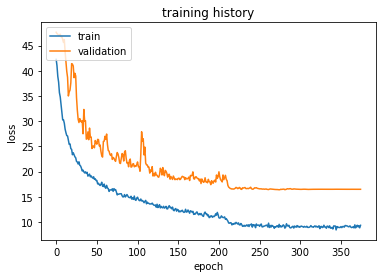

In [21]:
# train
history = model.fit(
    batch_size=8,             # adjust as training set expands
    validation_batch_size=2,  # adjust as training set expands
    callbacks=callbacks,
    epochs=800,
    n_workers=8,
    steps_per_epoch=None,     # set to None for automatic determination
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');